# Tutorial 08

## template fitting mock data test (EB mode, parametric CMB)

`Gaussian likelihood`:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

`H-L likelihood`:

$$ -2\log\mathcal{L} \propto vecp(D^fg[\frac{\hat{D}}{D+N}])^T \mathcal{M}_f^{-1} vecp(D^fg[\frac{\hat{D}}{D+N}]) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import afra as af
from afra.tools.ps_estimator import pstimator
from dynesty import utils as dyfunc
from getdist import plots, MCSamples
import warnings
warnings.filterwarnings('ignore')

TARGET = 'EB'
NSIDE = 128
NSAMP = 10
APOSCALE = 6.
LMIN = 30
LMAX = 151
PSBIN = 40
FREQS = [95.,150.]
FWHM = [(52.8/60.)*np.pi/180.,(19./60.)*np.pi/180.,(11./60.)*np.pi/180.,(4.94/60.)*np.pi/180.]
KWARGS = {'nlive':1000}

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')
ell = np.arange(cmb_cl.shape[1])

mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
fidcmb = np.empty((NSAMP,3,mapcmb.shape[1]),dtype=np.float32)
for i in range(NSAMP):
    fidcmb[i] = hp.smoothing(hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0),fwhm=FWHM[1],verbose=0)

vmap23 = hp.read_map('./data/wmapvar_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap23 = np.random.normal(0.,1.,size=(NSAMP,3,vmap23.shape[1]))*np.sqrt(vmap23)
nmap95 = np.random.normal(0.,1.,size=(NSAMP,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP,3,vmap150.shape[1]))*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=(NSAMP,3,vmap353.shape[1]))*np.sqrt(vmap353)

map23 = hp.smoothing(mapcmb+map23f,fwhm=FWHM[0],verbose=0)+nmap23[0]
map95 = hp.smoothing(mapcmb+map95f,fwhm=FWHM[1],verbose=0)+nmap95[0]
map150 = hp.smoothing(mapcmb+map150f,fwhm=FWHM[2],verbose=0)+nmap150[0]
map353 = hp.smoothing(mapcmb+map353f,fwhm=FWHM[3],verbose=0)+nmap353[0]

fullmap = {95:map95, 150:map150}

fullnoise = {95:nmap95, 150:nmap150}

fullbeam = {95:FWHM[1], 150:FWHM[2]}

fullfiducial = {95:fidcmb, 150:fidcmb}

fidbeam = {95:FWHM[1], 150:FWHM[1]}

without filter

iter: 8311 | +1000 | bound: 12 | nc: 1 | ncall: 54266 | eff(%): 17.158 | loglstar:   -inf < -0.026 <    inf | logz: -8.214 +/-  0.131 | dlogz:  0.001 >  1.009                                        

Removed no burn in
Removed no burn in
reduced chi-sq  0.0017043830693627773
reduced chi-sq  0.004292646907845833
CPU times: user 1h 8min 12s, sys: 41min 32s, total: 1h 49min 44s
Wall time: 16min 1s


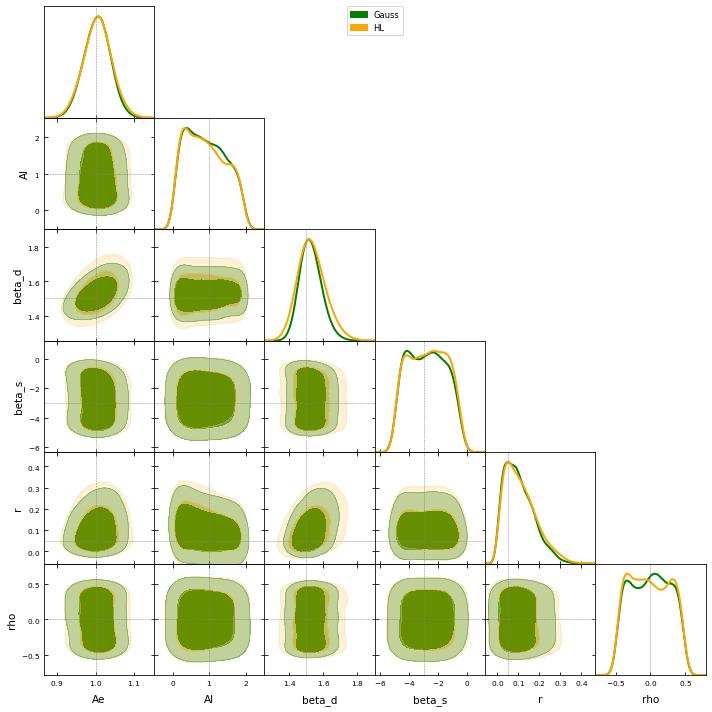

In [2]:
%%time

TARGET = 'EB'

tmpmap = {23:map23,353:map353}
tmpnoise = {23:nmap23,353:nmap353}
tmpbeam = {23:FWHM[0],353:FWHM[3]}

pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground='tsynctdust',background='acmb')
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

f = pipeline._foreground_obj
f.reset({'beta_s': -3.})
f.reset({'beta_d': 1.5})
f.reset({'rho': 0.})
b = pipeline._background_obj
b.reset({'Ae': 1.})
b.reset({'Al': 1.})
b.reset({'r': 0.05})
pipeline._background_obj = b
pipeline._foreground_obj = f
mock_bp = f.bandpower()+b.bandpower()

pipeline.likelihood='gauss'
result_g = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

###

names = pipeline.paramlist
truths = [1.,1.,1.5,-3.,0.05,0.]

samples, weights = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

samples, weights = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

print ('reduced chi-sq ',-2*max(result_g['logl'])/(len(pre_rslt[3])-len(names)))
print ('reduced chi-sq ',-2*max(result_h['logl'])/(len(pre_rslt[3])-len(names)))

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':2, 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

impose filtering matrix

In [3]:
Meb = np.load('./data/filtering_matrix_EB.npy')
nMeb = np.load('./data/filtering_matrix_nEB.npy')
Meb = np.identity(len(Meb))
nMeb = np.identity(len(Meb))
fullfilt = {'EB': Meb}

def manfilt(mat,bp_in):
    bp_filt = bp_in.copy()
    assert (len(bp_in) == len(TARGET))
    nfreq = bp_in.shape[-1]
    for i in range(nfreq):
        for j in range(nfreq):
            bp_filt[:,:,i,j] = mat.dot(bp_filt[:,:,i,j].reshape(-1,1)).reshape(len(TARGET),-1)
    return bp_filt

from afra.tools.aux import oas_cov, vec_gauss
def preprocess(pip,aposcale,psbin,lmin,lmax):
    # prepare ps estimator
    pip._estimator = pstimator(nside=pip._nside,mask=pip._mask,aposcale=aposcale,psbin=psbin,
                               lmin=lmin,lmax=lmax,targets=pip._targets,filt=pip._filt)
    # get templates
    if pip._template_flag:
        pip._template_bp = dict()
        for i in range(pip._template_nfreq):
            data_bp = np.zeros((pip._ntarget,pip._estimator.nmode),dtype=np.float32)
            noise_bp = np.zeros((pip._template_nsamp,pip._ntarget,pip._estimator.nmode),dtype=np.float32)
            _fi = pip._template_freqlist[i]
            stmp = pip._estimator.autoBP(pip._templates[_fi],fwhms=pip._template_fwhms[_fi])
            wsp = pip._estimator.autoWSP(pip._templates[_fi],fwhms=pip._template_fwhms[_fi])
            for t in range(pip._ntarget):
                data_bp[t] = stmp[1+t]
            for s in range(pip._template_nsamp):
                # auto correlation
                ntmp = pip._estimator.autoBP(pip._template_noises[_fi][s],wsp=wsp,fwhms=pip._template_fwhms[_fi])
                # assign results
                for t in range(pip._ntarget):
                    noise_bp[s,t] = ntmp[1+t]
            pip._template_bp[_fi] = data_bp - np.mean(noise_bp,axis=0)
    # prepare model, parameter list generated during init models
    if pip._background is not None:
        pip._background_obj = pip._background(pip._freqlist,pip._estimator)
    if pip._foreground is not None:
        pip._foreground_obj = pip._foreground(pip._freqlist,pip._estimator,pip._template_bp)
    # estimate X_hat and M
    wsp_dict = dict()  # wsp pool
    fwsp_dict = dict() # fiducial wsp pool
    data_bp = np.zeros((pip._ntarget,pip._estimator.nmode,pip._nfreq,pip._nfreq),dtype=np.float32)
    noise_bp = np.zeros((pip._nsamp,pip._ntarget,pip._estimator.nmode,pip._nfreq,pip._nfreq),dtype=np.float32)
    fiducial_bp = np.zeros((pip._nsamp,pip._ntarget,pip._estimator.nmode,pip._nfreq,pip._nfreq),dtype=np.float32)
    # filling wsp pool and estimated measured bandpowers
    for i in range(pip._nfreq):
        _fi = pip._freqlist[i]
        wsp_dict[(i,i)] = pip._estimator.autoWSP(pip._data[_fi],fwhms=pip._fwhms[_fi])
        fwsp_dict[(i,i)] = pip._estimator.autoWSP(pip._fiducials[_fi][0],fwhms=pip._fiducial_fwhms[_fi])
        stmp = pip._estimator.autoBP(pip._data[_fi],fwhms=pip._fwhms[_fi])
        for t in range(pip._ntarget):
            for k in range(pip._estimator.nmode):
                data_bp[t,k,i,i] = stmp[1+t][k]
        for j in range(i+1,pip._nfreq):
            _fj = pip._freqlist[j]
            wsp_dict[(i,j)] = pip._estimator.crosWSP(np.r_[pip._data[_fi],pip._data[_fj]],
                                                     fwhms=[pip._fwhms[_fi],pip._fwhms[_fj]])
            fwsp_dict[(i,j)] = pip._estimator.crosWSP(np.r_[pip._fiducials[_fi][0],pip._fiducials[_fj][0]],
                                                      fwhms=[pip._fiducial_fwhms[_fi],pip._fiducial_fwhms[_fj]])
            stmp = pip._estimator.crosBP(np.r_[pip._data[_fi],pip._data[_fj]],
                                         fwhms=[pip._fwhms[_fi],pip._fwhms[_fj]])
            for t in range(pip._ntarget):
                for k in range(pip._estimator.nmode):
                    data_bp[t,k,i,j] = stmp[1+t][k]
                    data_bp[t,k,j,i] = stmp[1+t][k]
    # work out estimations
    for s in range(pip._nsamp):
        # prepare noise samples on-fly
        for i in range(pip._nfreq):
            _fi = pip._freqlist[i]
            # auto correlation
            ntmp = pip._estimator.autoBP(pip._noises[_fi][s],wsp=wsp_dict[(i,i)],
                                         fwhms=pip._fwhms[_fi])
            stmp = pip._estimator.autoBP(pip._fiducials[_fi][s],wsp=fwsp_dict[(i,i)],
                                         fwhms=pip._fiducial_fwhms[_fi])
            ntmp = nMeb.dot(np.r_[ntmp[1],ntmp[2]]).reshape(2,-1)
            stmp = Meb.dot(np.r_[stmp[1],stmp[2]]).reshape(2,-1)
            # assign results
            for t in range(pip._ntarget):
                for k in range(pip._estimator.nmode):
                    noise_bp[s,t,k,i,i] = ntmp[t,k]
                    fiducial_bp[s,t,k,i,i] = stmp[t,k]+ntmp[t,k]
            # cross correlation
            for j in range(i+1,pip._nfreq):
                _fj = pip._freqlist[j]
                # cross correlation
                ntmp = pip._estimator.crosBP(np.r_[pip._noises[_fi][s],pip._noises[_fj][s]],
                                             wsp=wsp_dict[(i,j)],fwhms=[pip._fwhms[_fi],pip._fwhms[_fj]])
                stmp = pip._estimator.crosBP(np.r_[pip._fiducials[_fi][s],pip._fiducials[_fj][s]],
                                             wsp=fwsp_dict[(i,j)],
                                             fwhms=[pip._fiducial_fwhms[_fi],pip._fiducial_fwhms[_fj]])
                ntmp = nMeb.dot(np.r_[ntmp[1],ntmp[2]]).reshape(2,-1)
                stmp = Meb.dot(np.r_[stmp[1],stmp[2]]).reshape(2,-1)
                for t in range(pip._ntarget):
                    for k in range(pip._estimator.nmode):
                        noise_bp[s,t,k,i,j] = ntmp[t,k]
                        noise_bp[s,t,k,j,i] = ntmp[t,k]
                        fiducial_bp[s,t,k,i,j] = stmp[t,k]+ntmp[t,k]
                        fiducial_bp[s,t,k,j,i] = stmp[t,k]+ntmp[t,k]
    return ( data_bp, np.mean(fiducial_bp,axis=0), np.mean(noise_bp,axis=0), oas_cov(vec_gauss(fiducial_bp)) )

iter: 8279 | +1000 | bound: 12 | nc: 1 | ncall: 53853 | eff(%): 17.230 | loglstar:   -inf < -0.022 <    inf | logz: -8.198 +/-  0.133 | dlogz:  0.001 >  1.009                                        

Removed no burn in
Removed no burn in
reduced chi-sq  0.009400690274863401
reduced chi-sq  0.003619040080467092
CPU times: user 1h 5min 49s, sys: 36min 50s, total: 1h 42min 40s
Wall time: 14min 13s


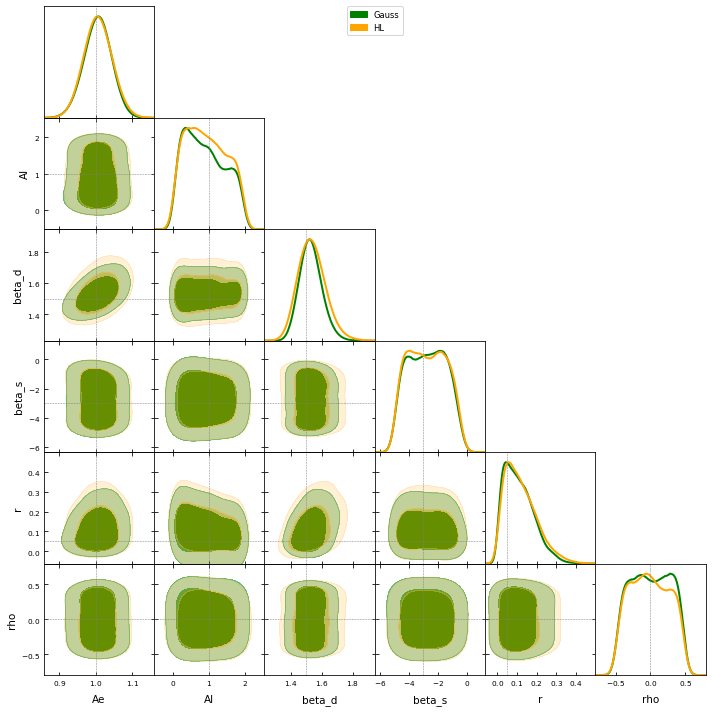

In [4]:
%%time

TARGET = 'EB'

tmpmap = {23:map23, 353:map353}
tmpnoise = {23:nmap23, 353:nmap353}
tmpbeam = {23:FWHM[0], 353:FWHM[3]}

pipeline = af.tpfpipe(fullmap,noises=fullnoise,mask=mask,fwhms=fullbeam,
                      fiducials=fullfiducial,fiducial_fwhms=fidbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets=TARGET,foreground='tsynctdust',background='acmb',filt=fullfilt)

pre_rslt = preprocess(pipeline,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

f = pipeline._foreground_obj
f.reset({'beta_s': -3.})
f.reset({'beta_d': 1.5})
f.reset({'rho': 0.})
b = pipeline._background_obj
b.reset({'Ae': 1.})
b.reset({'Al': 1.})
b.reset({'r': 0.05})
pipeline._background_obj = b
pipeline._foreground_obj = f
mock_bp = manfilt(Meb,f.bandpower()+b.bandpower())

pipeline.likelihood='gauss'
result_g = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

pipeline.likelihood='hl'
result_h = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

###

names = pipeline.paramlist
truths = [1.,1.,1.5,-3.,0.05,0.]

samples, weights = result_g.samples, np.exp(result_g.logwt - result_g.logz[-1])
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

samples, weights = result_h.samples, np.exp(result_h.logwt - result_h.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

print ('reduced chi-sq ',-2*max(result_g['logl'])/(len(pre_rslt[3])-len(names)))
print ('reduced chi-sq ',-2*max(result_h['logl'])/(len(pre_rslt[3])-len(names)))

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':2, 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

end